In [ ]:
### REMOVE LATER ###
# Go up one directory since notebook inside task3/ folder.
import os
try:
    if UP_DIR:
        print("skipping")
except NameError:
    os.chdir("..")
    UP_DIR = True

# JH's Task 3 Experiment 1
(NOTE: keep this H1 header block or add it later to denote the boundaries between notebooks when we combined later)

I don't know what I am doing yet for this.

## Imports

In [2]:
from dataclasses import dataclass

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import xgboost as xgb

## Hyperparameters

In [3]:
@dataclass
class Hparams:
    val_split: float = 0.2
    seed: int = 42
    
    pca_n_components = 100
    

HP = Hparams()

In [4]:
TRAIN_CSV = "./data/train.csv"
TRAIN_TFIDF_CSV = "./data/train_tfidf_features.csv"
TEST_CSV = "./data/test.csv"
TEST_TFIDF_CSV = "./data/test_tfidf_features.csv"

## Data Engineering
Instead of using the tfidf features given in the comp, we can engineer our own tfidf features with better filtering logic, or using something other than tfidf altogether to arrive at vector representations, or perhaps even use a strategy that use non-vector representations.

### Load Data

In [5]:
train_df = pd.read_csv(TRAIN_CSV, index_col="id")
train_tfidf_df = pd.read_csv(TRAIN_TFIDF_CSV, index_col="id")
test_df = pd.read_csv(TEST_CSV, index_col="id")
test_tfidf_df = pd.read_csv(TEST_TFIDF_CSV, index_col="id")

In [6]:
def tfidf_to_np(df: pd.DataFrame):
    """Convert the tfidf CSVs to X array of features and y array of labels, ordered
    by id.
    """
    df = df.sort_index()

    if "label" in df.columns:
        y = df.pop("label").to_numpy()
    else:
        y = None

    X = df.to_numpy()
    return X, y

In [7]:
train_X, val_X, train_y, val_y = train_test_split(*tfidf_to_np(train_tfidf_df), test_size=HP.val_split, random_state=HP.seed)
test_X, test_y = tfidf_to_np(test_tfidf_df)

print("Dataset splits:")
print("  train:", len(train_X))
print("  val:  ", len(val_X))
print("  test: ", len(test_X))

Dataset splits:
  train: 13747
  val:   3437
  test:  4296


### Fit PCA For Dim Reduction

In [8]:
model_pca = PCA(n_components=HP.pca_n_components, random_state=HP.seed)

model_pca.fit(train_X)

,n_components,100
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,42


In [15]:
ratios = list(zip(range(HP.pca_n_components), model_pca.explained_variance_ratio_))
ratios.sort(key=lambda x: x[1], reverse=True)

print("Most Informative Dimensions:")
for idx, val in ratios[:3]:
    print(f"  Dim {idx}: {val}")

print("Noise:", model_pca.noise_variance_)
print(sum(model_pca.explained_variance_))

Most Informative Dimensions:
  Dim 0: 0.010162737344708806
  Dim 1: 0.0067023549063708965
  Dim 2: 0.006077099321936864
Noise: 0.00015946004115722286
0.2076504969136641


In [16]:
t_train_X = model_pca.transform(train_X)
t_val_X = model_pca.transform(val_X)
t_test_X = model_pca.transform(test_X)

## Fit XGBoost
Its boosted trees or random forests for both classification or regression.

Tutorial: <https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters>

In [ ]:
dtrain = xgb.DMatrix(t_train_X, label=train_y)
dval = xgb.DMatrix(t_val_X, label=val_y)

In [18]:
# https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
params = {
    "validate_parameters": True,

    "colsample_bynode": 0.8,
    "learning_rate": 0.3,
    "max_depth": 5,
    "num_parallel_tree": 20,
    "objective": "binary:hinge",
    "subsample": 0.8,

    "tree_method": "hist",
    "device": "gpu",
}
num_round = 100
early_stopping_rounds = 10
# Last set is used by xgb's early stopping.
eval_list = [(dtrain, "train"), (dval, "val")]

In [19]:
results = {}
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evals=eval_list,
    evals_result=results,
    early_stopping_rounds=early_stopping_rounds,
)

[0]	train-error:0.30508	val-error:0.32441
[1]	train-error:0.30399	val-error:0.32703
[2]	train-error:0.30508	val-error:0.32616
[3]	train-error:0.30450	val-error:0.32557
[4]	train-error:0.30385	val-error:0.32587
[5]	train-error:0.30421	val-error:0.32557
[6]	train-error:0.30196	val-error:0.32499
[7]	train-error:0.29832	val-error:0.32267
[8]	train-error:0.29621	val-error:0.31946
[9]	train-error:0.29519	val-error:0.31976
[10]	train-error:0.29301	val-error:0.31888
[11]	train-error:0.29105	val-error:0.31859
[12]	train-error:0.28770	val-error:0.31946
[13]	train-error:0.28421	val-error:0.31772
[14]	train-error:0.28115	val-error:0.31772
[15]	train-error:0.27897	val-error:0.31859
[16]	train-error:0.27635	val-error:0.31656
[17]	train-error:0.27381	val-error:0.31597
[18]	train-error:0.27148	val-error:0.31568
[19]	train-error:0.26871	val-error:0.31510
[20]	train-error:0.26668	val-error:0.31510
[21]	train-error:0.26500	val-error:0.31481
[22]	train-error:0.26246	val-error:0.31423
[23]	train-error:0.25

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

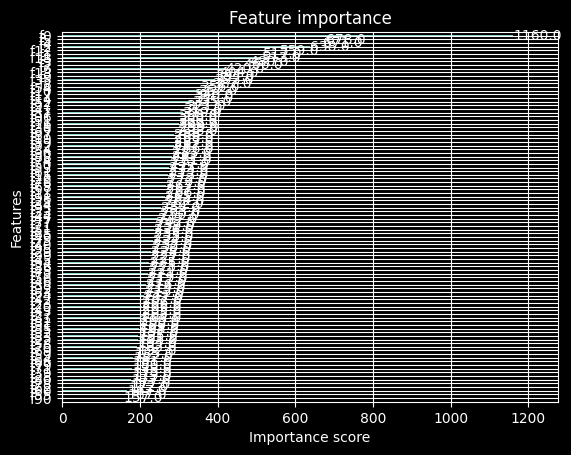

In [20]:
xgb.plot_importance(bst)

## Inference

In [23]:
dtest = xgb.DMatrix(t_test_X)

pred_y = bst.predict(dtest, iteration_range=(0, bst.best_iteration+1))

In [28]:
pred_df = pd.DataFrame(zip(test_tfidf_df.index, pred_y.astype(int)), columns=["id", "label"])
pred_df.to_csv("submission.csv", index=False)